# Training the model

This notebook is for training the model. If your machine is not set up for running tensorflow with GPU acceleration it is not recommended that you run this as training will be very very slow.

We trained this model on an RTX 3070 TI and it took around 400 epochs, give or take,  to train.

In [2]:
import numpy as np
import seaborn as sns
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import os
tensorflow.config.list_physical_devices('GPU') # If this returns [], then GPU support is not set up. Training will be SLOWWWW!

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### First, we load the data into a training set and a validation set

In [4]:
# size of the image: 48*48 pixels
pic_size = 48

base_path = "./images/"

class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# num_img is the maximum number of images to pull from each expression. e.g. num_img=500 would pull 500 angry, 500 disgust, etc.
def load_data(dataset="train", num_img=100000):
    images = []
    classes = []
    for expression in os.listdir(base_path + dataset):
        for img_file in os.listdir(base_path + dataset + "/" + expression)[:num_img]:
            img = load_img(base_path + dataset + "/" + expression + "/" + img_file, target_size=(pic_size, pic_size), color_mode='grayscale')
            images.append(img_to_array(img))
            classes.append(class_names.index(expression))

    return (np.array(images) / 255, np.array(classes))

x_train, y_train = load_data("train") # TRAINING set: This is the data used to train the model
x_val, y_val = load_data("validation") # VALIDATION set: This is the data used to track the accuracy and progress of the model as it trains

np.random.seed(42)
np.random.shuffle(x_train)
np.random.seed(42)
np.random.shuffle(y_train)
np.random.seed(42)
np.random.shuffle(x_val)
np.random.seed(42)
np.random.shuffle(y_val)

print(f"Training on {len(x_train)} images")

Training on 28821 images


### Here's a sample of some of the training data:

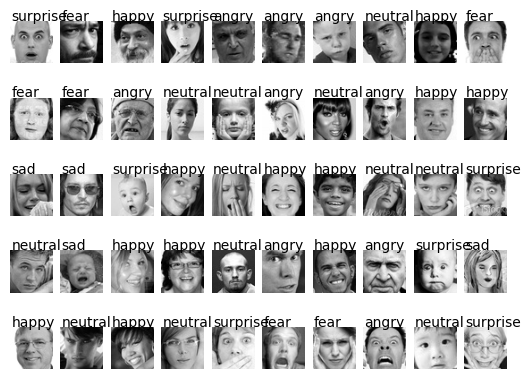

In [5]:
plt.tight_layout()
for i in range(50):
    idx = np.random.choice(np.arange(x_train.shape[0]))
    img = x_train[idx]
    plt.subplot(5,10, i+1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.text(1, -1, class_names[y_train[idx]])


plt.show()

### Next, we create the model.
It's been mostly trial and error, but this model has been able to achieve 63% accuracy which is the best we've been able to get. It consists of 3 convolutional layers with various sized kernels (5x5, 3x3, and 2x2), and 5 fully connected layers.

In order to reduce overfitting, each CNN and fully connected layer uses Dropout, and each fully connected layer uses an L2 regularizer. (Recommended by [this tensorflow article](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#add_dropout))



In [7]:
model = keras.models.Sequential()
#1st CNN layer
model.add(Conv2D(64,(5,5),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))
#2nd CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))

#3rd CNN layer
model.add(Conv2D(64,(2,2),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))
model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))


# Fully connected layer 2nd layer
model.add(Dense(512, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Fully connected layer 3rd layer
model.add(Dense(256, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Fully connected layer 4th layer
model.add(Dense(512, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Fully connected layer 5th layer
model.add(Dense(256, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(len(class_names), activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)       

We can also reset the random seed so we don't get wildly different results each run:

In [8]:
keras.backend.clear_session()
np.random.seed(42)
tensorflow.random.set_seed(42)

### Now we compile the model.
The approach I used to train this was to start out with a learning rate of 0.0001, train for 50 epochs, then reduce the learning rate and resume training from the epoch that resulted in the lowest loss from the previous run. Repeating this a couple times allowed us to reach 63% accuracy.

In [9]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.00001), metrics=["accuracy"])

### IMPORTANT: ONLY RUN THIS CELL IF YOU WANT TO RESUME PROGRESS FROM A PREVIOUS RUN
It will load the weights from the saved epoch with the lowest loss.

If you want to train the model from scratch, simply skip this cell

In [12]:
checkpoints = os.listdir('checkpoints')
if (len(checkpoints) > 0):
    checkpoints.sort()
    print("Loading " + checkpoints[0])
    model.load_weights('checkpoints/' + os.listdir('checkpoints')[-1]) # Load the best model so far
else:
    print("No model to load from")

Loading model-1.1016-05-.h5


### Train the model. This will save the best weights from this run in the checkpoints/ folder.

In [13]:
checkpoint = ModelCheckpoint(filepath="checkpoints/model-{val_loss:.4f}-{epoch:02d}-.h5", save_freq='epoch', monitor='val_loss', save_weights_only=True, save_best_only=True)
early_stopping = EarlyStopping(restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val), batch_size=500, callbacks=[checkpoint])

Epoch 1/1000
58/58 [==============================] - 4s 69ms/step - loss: 1.0908 - accuracy: 0.6353 - val_loss: 1.1053 - val_accuracy: 0.6298
Epoch 2/1000
58/58 [==============================] - 4s 70ms/step - loss: 1.0878 - accuracy: 0.6338 - val_loss: 1.1066 - val_accuracy: 0.6289
Epoch 3/1000
58/58 [==============================] - 4s 68ms/step - loss: 1.0857 - accuracy: 0.6340 - val_loss: 1.1054 - val_accuracy: 0.6315
Epoch 4/1000
58/58 [==============================] - 4s 62ms/step - loss: 1.0906 - accuracy: 0.6358 - val_loss: 1.1040 - val_accuracy: 0.6320
Epoch 5/1000
58/58 [==============================] - 4s 62ms/step - loss: 1.0899 - accuracy: 0.6349 - val_loss: 1.1053 - val_accuracy: 0.6302
Epoch 6/1000
58/58 [==============================] - 4s 62ms/step - loss: 1.0731 - accuracy: 0.6393 - val_loss: 1.1051 - val_accuracy: 0.6316
Epoch 7/1000
58/58 [==============================] - 4s 62ms/step - loss: 1.0809 - accuracy: 0.6365 - val_loss: 1.1029 - val_accuracy: 0.6318

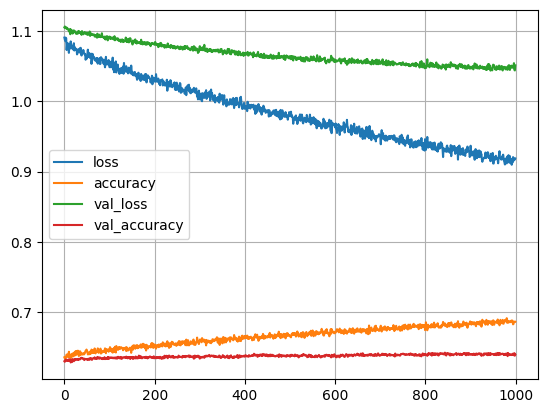

In [14]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.grid(True)

In [15]:
model.evaluate(x_val, y_val)

221/221 [==============================] - 1s 5ms/step - loss: 1.0512 - accuracy: 0.6388


[1.0511738061904907, 0.6388338804244995]

### Now, go to test.ipynb to see the model in action.